In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
import datetime
import time
import math
import warnings
warnings.filterwarnings("ignore")
import glob

from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint
from keras.models import load_model
from tensorflow.keras.optimizers import Adam
from keras.regularizers import l2
import time

In [13]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13176315813264218545
]


In [14]:
def read_house_data(house):
    # path = '/kaggle/input/pakistan-residential-electricity-consumption/House{}.csv'.format(house)
    path = 'precon_dataset/House{}.csv'.format(house)
    df = pd.read_csv(path)
    df['Date_Time'] = df['Date_Time'].astype("datetime64[s]")
    df = df.set_index(df['Date_Time'].values)
    df.drop(['Date_Time'], axis=1, inplace=True)
    return df

df = {}
# for i in range(1,10):
#     df[i] = read_house_data(i)


# Hosue 2 and 4
df[1] = read_house_data(4)
df1_mains2 =  df[1].iloc[:,1:].sum(axis=1)
df[1].insert(loc = 1,column = 'Sum_kW',value = df1_mains2)

df[2] = read_house_data(2)
df2_mains2 =  df[2].iloc[:,1:].sum(axis=1)
df[2].insert(loc = 1,column = 'Sum_kW',value = df2_mains2)

In [15]:
for i in range(1,3):
    print('House {} data has shape: '.format(i), df[i].shape)
    display(df[i].tail(3))

House 1 data has shape:  (525600, 7)


Usage_kW  Sum_kW  AC_DR_kW  Kitchen_kW  AC_BR_kW  \
2019-05-31 23:57:00    4.4730  2.0375    0.0002      0.1980    1.0414   
2019-05-31 23:58:00    4.3807  1.9472    0.0001      0.1973    0.9526   
2019-05-31 23:59:00    4.2567  1.8295    0.0000      0.1960    0.8361   

                     AC_LR_kW  AC_MBR_kW  
2019-05-31 23:57:00    0.0102     0.7877  
2019-05-31 23:58:00    0.0101     0.7871  
2019-05-31 23:59:00    0.0100     0.7874

House 2 data has shape:  (525600, 7)


Usage_kW  Sum_kW  AC_LR_kW  AC_DR_kW  AC_BR_kW  \
2019-05-31 23:57:00    2.9424  1.0753    0.0001    0.0002    0.9637   
2019-05-31 23:58:00    2.9787  1.0938    0.0000    0.0001    0.9822   
2019-05-31 23:59:00    2.9385  1.0663    0.0001    0.0001    0.9526   

                     Kitchen_kW  UPS_kW  
2019-05-31 23:57:00      0.0005  0.1108  
2019-05-31 23:58:00      0.0005  0.1110  
2019-05-31 23:59:00      0.0005  0.1130

In [16]:
dates = {}
for i in range(1,3):
    dates[i] = [str(time)[:10] for time in df[i].index.values]
    dates[i] = sorted(list(set(dates[i])))
    print('House {0} data contain {1} days from {2} to {3}.'.format(i,len(dates[i]),dates[i][0], dates[i][-1]))
    print(dates[i], '\n')

House 1 data contain 365 days from 2018-06-01 to 2019-05-31.
['2018-06-01', '2018-06-02', '2018-06-03', '2018-06-04', '2018-06-05', '2018-06-06', '2018-06-07', '2018-06-08', '2018-06-09', '2018-06-10', '2018-06-11', '2018-06-12', '2018-06-13', '2018-06-14', '2018-06-15', '2018-06-16', '2018-06-17', '2018-06-18', '2018-06-19', '2018-06-20', '2018-06-21', '2018-06-22', '2018-06-23', '2018-06-24', '2018-06-25', '2018-06-26', '2018-06-27', '2018-06-28', '2018-06-29', '2018-06-30', '2018-07-01', '2018-07-02', '2018-07-03', '2018-07-04', '2018-07-05', '2018-07-06', '2018-07-07', '2018-07-08', '2018-07-09', '2018-07-10', '2018-07-11', '2018-07-12', '2018-07-13', '2018-07-14', '2018-07-15', '2018-07-16', '2018-07-17', '2018-07-18', '2018-07-19', '2018-07-20', '2018-07-21', '2018-07-22', '2018-07-23', '2018-07-24', '2018-07-25', '2018-07-26', '2018-07-27', '2018-07-28', '2018-07-29', '2018-07-30', '2018-07-31', '2018-08-01', '2018-08-02', '2018-08-03', '2018-08-04', '2018-08-05', '2018-08-06', 

In [17]:
# Separating house 1 data into train, validation and test data
df1_train = df[1].loc[:dates[1][250]]
df1_val = df[1].loc[dates[1][251]:dates[1][325]]
df1_test = df[1].loc[dates[1][326]:]
print('df_train.shape: ', df1_train.shape)
print('df_val.shape: ', df1_val.shape)
print('df_test.shape: ', df1_test.shape)

df_train.shape:  (361440, 7)
df_val.shape:  (108000, 7)
df_test.shape:  (56160, 7)


In [18]:
def build_lstm_model(layers):
    model = Sequential()
    i = 0
    for i in range(len(layers) - 2):
        model.add(LSTM(
            input_dim=layers[i],
            units=layers[i+1],
            #stateful=True,
            return_sequences= True if i < len(layers) - 3 else False ))
        model.add(Dropout(0.3))

    model.add(Dense(layers[-1]))
    model.summary()
    return model

model = build_lstm_model([2,64,128,256, 1])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, None, 64)          17152     
_________________________________________________________________
dropout (Dropout)            (None, None, 64)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 128)         98816     
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128)         0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               394240    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 2

In [19]:
def process_data(df, dates, x_features, y_features, look_back = 50):
    i = 0
    for date in dates:
        data = df.loc[date]
        len_data = data.shape[0]
        x = np.array([data[x_features].values[i:i+look_back]
                      for i in range(len_data - look_back) ]).reshape(-1,look_back, 2)
        y = data[y_features].values[look_back:,:]
        if i == 0:
            X = x
            Y = y
        else:
            X = np.append(X, x, axis=0)
            Y = np.append(Y, y, axis=0)
        i += 1
    return X,Y

In [20]:
start = time.time()
X_train, y_train = process_data(df[1], dates[1][:326], ['Usage_kW','Sum_kW'], df[1].columns.values[2:])
X_test, y_test = process_data(df[1], dates[1][326:], ['Usage_kW','Sum_kW'], df[1].columns.values[2:])
print('Process data time: ', time.time() - start)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

Process data time:  248.6176769733429
(453140, 50, 2) (453140, 5) (54210, 50, 2) (54210, 5)


In [21]:
print(df[1].columns.values[2:])

['AC_DR_kW' 'Kitchen_kW' 'AC_BR_kW' 'AC_LR_kW' 'AC_MBR_kW']


In [22]:
start = time.time()
adam = Adam(lr = 5e-5)
model.compile(loss='mean_squared_error', optimizer=adam)
checkpointer = ModelCheckpoint(filepath="./lstm_model.hdf5", verbose=0, save_best_only=True)
hist_lstm = model.fit(
            X_train,
            y_train[:,1],
            batch_size=512,
            verbose=1,
            epochs=1,
            validation_split=0.3,
            callbacks=[checkpointer])
print('Finish trainning. Time: ', time.time() - start)

620/620 [==============================] - 1406s 2s/step - loss: 0.0316 - val_loss: 0.0249
Finish trainning. Time:  1406.4627137184143


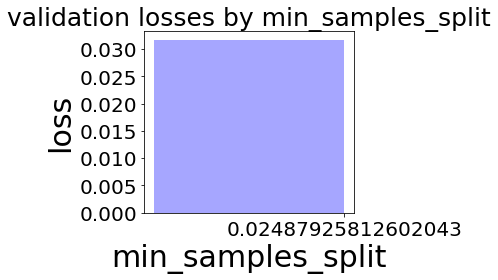

In [23]:
def plot_losses(losses, min_samples_split):
    index = np.arange(len(min_samples_split))
    bar_width = 0.3
    opacity = 0.35

    plt.bar(index, losses, bar_width, alpha=opacity, color='b')
    plt.xlabel('min_samples_split', fontsize=30)
    plt.ylabel('loss', fontsize=30)
    plt.title('validation losses by min_samples_split', fontsize = '25')
    plt.xticks(index + bar_width/2, min_samples_split, fontsize=20 )
    plt.yticks(fontsize=20 )
    plt.rcParams["figure.figsize"] = [24,15]
    plt.tight_layout()


train_loss = hist_lstm.history['loss']
val_loss = hist_lstm.history['val_loss']

plot_losses(train_loss, val_loss)

In [24]:
model = load_model('lstm_model.hdf5')
pred_lstm = model.predict(X_test).reshape(-1)
print(pred_lstm.shape)


(54210,)


In [25]:
def mse_loss(y_predict, y):
    return np.mean(np.square(y_predict - y))
def mae_loss(y_predict, y):
    return np.mean(np.abs(y_predict - y))


mse_loss_lstm = mse_loss(pred_lstm, y_test[:,1])
mae_loss_lstm = mae_loss(pred_lstm, y_test[:,1])
print('Mean square error on test set: ', mse_loss_lstm)
print('Mean absolute error on the test set: ', mae_loss_lstm)

Mean square error on test set:  0.019366225663830672
Mean absolute error on the test set:  0.11324053820382031


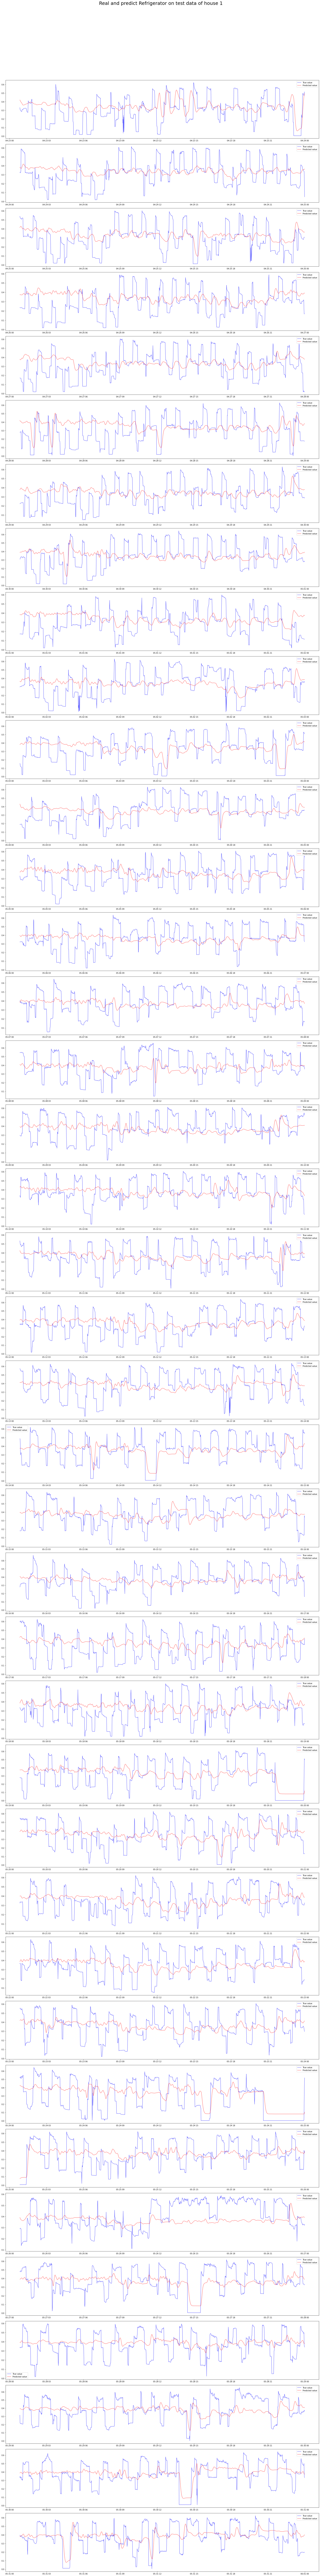

In [26]:
def plot_each_app(df, dates, predict, y_test, title, look_back = 0):
    num_date = len(dates)
    fig, axes = plt.subplots(num_date,1,figsize=(24, num_date*5) )
    plt.suptitle(title, fontsize = '25')
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    for i in range(num_date):
        if i == 0: l = 0
        ind = df.loc[dates[i]].index[look_back:]
        display()
        axes.flat[i].plot(ind, y_test[l:l+len(ind)], color = 'blue', alpha = 0.6, label = 'True value')
        axes.flat[i].plot(ind, predict[l:l+len(ind)], color = 'red', alpha = 0.6, label = 'Predicted value')
        axes.flat[i].legend()
        l = l+len(ind)

plot_each_app(df1_test, dates[1][326:], pred_lstm, y_test[:,1],
              'Real and predict Refrigerator on test data of house 1', look_back = 50)

### Test LST model on house 2

In [29]:
start = time.time()
X_2, y_2 = process_data(df[2], dates[2], ['Usage_kW','Sum_kW'], ['Kitchen_kW'])
X_2_fc = X_2.reshape(-1, 100)
y_2 = y_2.reshape(-1)
print('Process data time: ', time.time() - start)
print(X_2_fc.shape, y_2.shape)

Process data time:  237.8960452079773
(507350, 100) (507350,)


In [30]:

pred_lstm_h2 = model.predict(X_2).reshape(-1)
mse_loss_lstm_h2 = mse_loss(pred_lstm_h2, y_2)
mae_loss_lstm_h2 = mae_loss(pred_lstm_h2, y_2)
print('Mean square error on test set: ', mse_loss_lstm_h2)
print('Mean absolute error on the test set: ', mae_loss_lstm_h2)

Mean square error on test set:  0.03713161657300573
Mean absolute error on the test set:  0.17032978839335375


In [42]:
print(pred_lstm_h2[50:60])
print(y_2[50:60])

[0.23281835 0.23222794 0.23168012 0.23116723 0.23069611 0.23027815
 0.22991581 0.229612   0.22928415 0.2289174 ]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


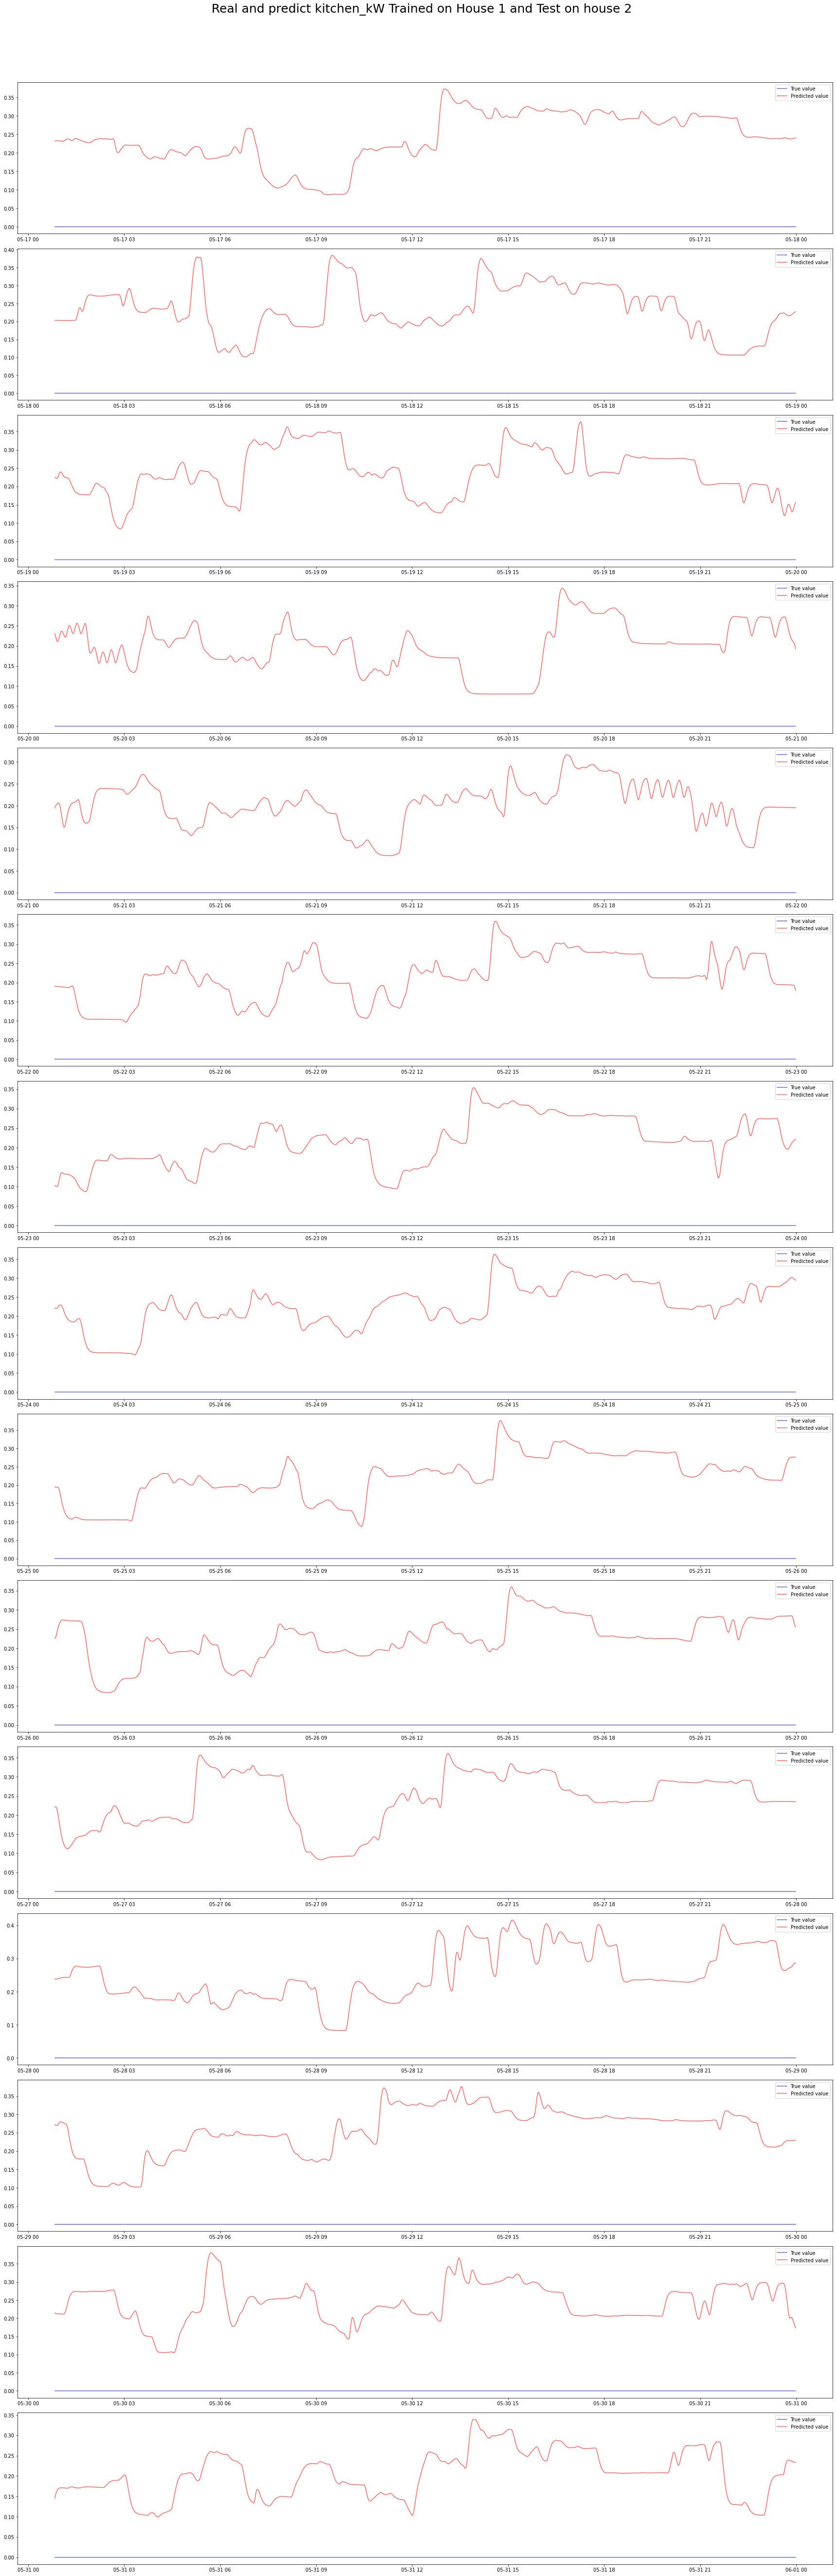

In [36]:
plot_each_app(df[2], dates[2][350:], pred_lstm_h2, y_2,
              'Real and predict kitchen_kW Trained on House 1 and Test on house 2', look_back = 50)